In [9]:
import pyspark as ps
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf, col, when
import numpy as np

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
# Create a spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()

In [4]:
import pandas as pd

df = pd.read_csv("data/2020-Jan.csv")

In [5]:
df.shape[0]

1048575

In [6]:
df['event_time'] = pd.to_datetime(df['event_time'], utc=True)

In [7]:
df = df.sort_values(by=["user_session", "event_time"])

In [8]:
df['user_session'].isna().sum()

211

In [9]:
df = df.dropna(subset=['user_session'])

In [10]:
df['time_spent'] = 0

In [11]:
df.iloc[12785, 8]

'03490947-fd90-47a8-bda0-1241ac9b95ea'

In [12]:
n = df.shape[0]-1
for i in range(n):
    if df.iloc[i, 8] == df.iloc[i+1, 8]:
        df.iloc[i, 9] = (df.iloc[i+1, 0] - df.iloc[i, 0])/np.timedelta64(1,'s')

In [13]:
df.head(10)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,time_spent
59279,2020-01-01 19:09:23+00:00,view,5836522,1.487580e+18,NaN,nagaraku,0.40,595694304,00001ca1-f2df-4572-b0b8-e752e2064aae,0
476016,2020-01-05 14:37:00+00:00,view,5916099,1.487580e+18,NaN,NaN,53.17,586567117,00016afd-2d67-4e6e-8918-1243249acc34,0
776669,2020-01-08 03:03:26+00:00,view,5729012,1.487580e+18,NaN,cnd,10.00,561127846,00017b33-a65a-41b5-bd28-a2bfdd71ca3e,0
723864,2020-01-07 17:02:15+00:00,view,5820529,1.487580e+18,NaN,shary,2.06,598033041,00017f26-9070-49d7-a809-cdfe0be5ef1d,0
707415,2020-01-07 14:47:43+00:00,view,5854828,1.602940e+18,NaN,grattol,5.24,456938834,00019bed-3c6e-4d29-86de-75bafbdf978c,0
279270,2020-01-03 19:46:50+00:00,view,5766316,1.487580e+18,NaN,NaN,14.29,596483915,0001d5ff-c169-4bc4-b0e2-d45586a2f6d9,17
279292,2020-01-03 19:47:07+00:00,view,5766282,1.487580e+18,NaN,NaN,14.29,596483915,0001d5ff-c169-4bc4-b0e2-d45586a2f6d9,0
641196,2020-01-06 22:01:24+00:00,view,5799898,1.487580e+18,NaN,NaN,24.29,558452379,0001de3e-3a52-44dd-879b-d67e0a45489a,0
357269,2020-01-04 14:30:25+00:00,view,5849378,1.542200e+18,NaN,bioaqua,12.54,552255940,00035747-f915-42f1-8cef-e480ff0ce583,38
357325,2020-01-04 14:31:03+00:00,view,5916414,1.487580e+18,NaN,NaN,7.86,552255940,00035747-f915-42f1-8cef-e480ff0ce583,80


In [14]:
df.to_csv("ecommerce_history.csv")

In [42]:
import pandas as pd

df = pd.read_csv("ecommerce_history.csv")

In [43]:
df = df[df['time_spent']!=0]

In [44]:
df.shape[0]

693994

In [45]:
new_df = df.copy()

In [46]:
len(new_df)

693994

In [49]:
new_df.rename(columns={'Unnamed: 0':'original_index'}, inplace=True)
new_df.head(10)

,original_index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,time_spent
5,279270,2020-01-03 19:46:50+00:00,view,5766316,1.487580e+18,NaN,NaN,14.29,596483915,0001d5ff-c169-4bc4-b0e2-d45586a2f6d9,17
8,357269,2020-01-04 14:30:25+00:00,view,5849378,1.542200e+18,NaN,bioaqua,12.54,552255940,00035747-f915-42f1-8cef-e480ff0ce583,38
9,357325,2020-01-04 14:31:03+00:00,view,5916414,1.487580e+18,NaN,NaN,7.86,552255940,00035747-f915-42f1-8cef-e480ff0ce583,80
10,357431,2020-01-04 14:32:23+00:00,cart,5899248,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,7
11,357449,2020-01-04 14:32:30+00:00,view,5899248,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,24
12,357492,2020-01-04 14:32:54+00:00,view,5899249,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,15
13,357513,2020-01-04 14:33:09+00:00,view,5899247,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,334
14,358161,2020-01-04 14:38:43+00:00,cart,5887756,1.487580e+18,NaN,NaN,3.56,552255940,00035747-f915-42f1-8cef-e480ff0ce583,6
15,358175,2020-01-04 14:38:49+00:00,cart,5887756,1.487580e+18,NaN,NaN,3.56,552255940,00035747-f915-42f1-8cef-e480ff0ce583,21
16,358224,2020-01-04 14:39:10+00:00,view,5887734,1.487580e+18,NaN,NaN,2.49,552255940,00035747-f915-42f1-8cef-e480ff0ce583,82


In [50]:
new_df.reset_index(inplace=True)

In [53]:
new_df.drop('index', axis=1, inplace=True)

In [54]:
new_df.head(10)

,original_index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,time_spent
0,279270,2020-01-03 19:46:50+00:00,view,5766316,1.487580e+18,NaN,NaN,14.29,596483915,0001d5ff-c169-4bc4-b0e2-d45586a2f6d9,17
1,357269,2020-01-04 14:30:25+00:00,view,5849378,1.542200e+18,NaN,bioaqua,12.54,552255940,00035747-f915-42f1-8cef-e480ff0ce583,38
2,357325,2020-01-04 14:31:03+00:00,view,5916414,1.487580e+18,NaN,NaN,7.86,552255940,00035747-f915-42f1-8cef-e480ff0ce583,80
3,357431,2020-01-04 14:32:23+00:00,cart,5899248,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,7
4,357449,2020-01-04 14:32:30+00:00,view,5899248,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,24
5,357492,2020-01-04 14:32:54+00:00,view,5899249,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,15
6,357513,2020-01-04 14:33:09+00:00,view,5899247,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,334
7,358161,2020-01-04 14:38:43+00:00,cart,5887756,1.487580e+18,NaN,NaN,3.56,552255940,00035747-f915-42f1-8cef-e480ff0ce583,6
8,358175,2020-01-04 14:38:49+00:00,cart,5887756,1.487580e+18,NaN,NaN,3.56,552255940,00035747-f915-42f1-8cef-e480ff0ce583,21
9,358224,2020-01-04 14:39:10+00:00,view,5887734,1.487580e+18,NaN,NaN,2.49,552255940,00035747-f915-42f1-8cef-e480ff0ce583,82


In [56]:
n = new_df.shape[0]
sum_of_time_spent = {}
for i in range(n):
    if new_df.iloc[i, 8] in sum_of_time_spent:
        sum_of_time_spent[new_df.iloc[i, 8]]+=new_df.iloc[i, 10]
    else:
        sum_of_time_spent[new_df.iloc[i, 8]] = new_df.iloc[i, 10]

In [57]:
for i in range(n):
    new_df.iloc[i, 10] = new_df.iloc[i, 10] / sum_of_time_spent[new_df.iloc[i, 8]]

In [58]:
new_df

,original_index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,time_spent
0,279270,2020-01-03 19:46:50+00:00,view,5766316,1.487580e+18,NaN,NaN,14.29,596483915,0001d5ff-c169-4bc4-b0e2-d45586a2f6d9,1.000000
1,357269,2020-01-04 14:30:25+00:00,view,5849378,1.542200e+18,NaN,bioaqua,12.54,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.012562
2,357325,2020-01-04 14:31:03+00:00,view,5916414,1.487580e+18,NaN,NaN,7.86,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.026446
3,357431,2020-01-04 14:32:23+00:00,cart,5899248,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.002314
4,357449,2020-01-04 14:32:30+00:00,view,5899248,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.007934
...,...,...,...,...,...,...,...,...,...,...,...
693989,95007,2020-01-02 07:48:50+00:00,cart,5841832,1.487580e+18,NaN,NaN,5.54,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.014327
693990,95018,2020-01-02 07:49:00+00:00,cart,5713405,1.487580e+18,NaN,NaN,7.30,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.022923
693991,95037,2020-01-02 07:49:16+00:00,cart,5713404,1.487580e+18,NaN,NaN,7.30,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.060172
693992,1013060,2020-01-09 18:41:19+00:00,view,5857906,1.784000e+18,NaN,NaN,5.56,598961942,fffc10d8-c534-4aac-8c21-444aa4b165e4,1.000000


In [59]:
new_df = new_df[(new_df['time_spent'] > 0.01) & (new_df['time_spent'] < 1.0)]

In [61]:
new_df

,original_index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,time_spent
1,357269,2020-01-04 14:30:25+00:00,view,5849378,1.542200e+18,NaN,bioaqua,12.54,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.012562
2,357325,2020-01-04 14:31:03+00:00,view,5916414,1.487580e+18,NaN,NaN,7.86,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.026446
6,357513,2020-01-04 14:33:09+00:00,view,5899247,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.110413
9,358224,2020-01-04 14:39:10+00:00,view,5887734,1.487580e+18,NaN,NaN,2.49,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.027107
10,358404,2020-01-04 14:40:32+00:00,cart,5887734,1.487580e+18,NaN,NaN,2.49,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.034050
...,...,...,...,...,...,...,...,...,...,...,...
693988,94957,2020-01-02 07:48:04+00:00,cart,5713402,1.487580e+18,NaN,NaN,8.25,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.065903
693989,95007,2020-01-02 07:48:50+00:00,cart,5841832,1.487580e+18,NaN,NaN,5.54,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.014327
693990,95018,2020-01-02 07:49:00+00:00,cart,5713405,1.487580e+18,NaN,NaN,7.30,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.022923
693991,95037,2020-01-02 07:49:16+00:00,cart,5713404,1.487580e+18,NaN,NaN,7.30,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.060172


In [62]:
new_df.to_csv("normalized_time.csv")

In [3]:
import pandas as pd

df = pd.read_csv("normalized_time.csv")

In [29]:
df

,Unnamed: 0,original_index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,time_spent
0,1,357269,2020-01-04 14:30:25+00:00,view,5849378,1.542200e+18,NaN,bioaqua,12.54,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.012562
1,2,357325,2020-01-04 14:31:03+00:00,view,5916414,1.487580e+18,NaN,NaN,7.86,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.026446
2,6,357513,2020-01-04 14:33:09+00:00,view,5899247,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.110413
3,9,358224,2020-01-04 14:39:10+00:00,view,5887734,1.487580e+18,NaN,NaN,2.49,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.027107
4,10,358404,2020-01-04 14:40:32+00:00,cart,5887734,1.487580e+18,NaN,NaN,2.49,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.034050
...,...,...,...,...,...,...,...,...,...,...,...,...
292020,693988,94957,2020-01-02 07:48:04+00:00,cart,5713402,1.487580e+18,NaN,NaN,8.25,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.065903
292021,693989,95007,2020-01-02 07:48:50+00:00,cart,5841832,1.487580e+18,NaN,NaN,5.54,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.014327
292022,693990,95018,2020-01-02 07:49:00+00:00,cart,5713405,1.487580e+18,NaN,NaN,7.30,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.022923
292023,693991,95037,2020-01-02 07:49:16+00:00,cart,5713404,1.487580e+18,NaN,NaN,7.30,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.060172


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [31]:
df

,original_index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,time_spent
0,357269,2020-01-04 14:30:25+00:00,view,5849378,1.542200e+18,NaN,bioaqua,12.54,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.012562
1,357325,2020-01-04 14:31:03+00:00,view,5916414,1.487580e+18,NaN,NaN,7.86,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.026446
2,357513,2020-01-04 14:33:09+00:00,view,5899247,1.487580e+18,NaN,NaN,4.43,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.110413
3,358224,2020-01-04 14:39:10+00:00,view,5887734,1.487580e+18,NaN,NaN,2.49,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.027107
4,358404,2020-01-04 14:40:32+00:00,cart,5887734,1.487580e+18,NaN,NaN,2.49,552255940,00035747-f915-42f1-8cef-e480ff0ce583,0.034050
...,...,...,...,...,...,...,...,...,...,...,...
292020,94957,2020-01-02 07:48:04+00:00,cart,5713402,1.487580e+18,NaN,NaN,8.25,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.065903
292021,95007,2020-01-02 07:48:50+00:00,cart,5841832,1.487580e+18,NaN,NaN,5.54,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.014327
292022,95018,2020-01-02 07:49:00+00:00,cart,5713405,1.487580e+18,NaN,NaN,7.30,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.022923
292023,95037,2020-01-02 07:49:16+00:00,cart,5713404,1.487580e+18,NaN,NaN,7.30,595186898,fffaf3a1-6850-4582-b582-d0597f2ca066,0.060172


In [6]:
df['time_spent'].mean()

0.11707274006601076

In [33]:
count = df['time_spent'].value_counts().tolist()

In [34]:
weighted_avg = df['time_spent'].value_counts().index.tolist()

In [35]:
time_df = pd.DataFrame(list(zip(weighted_avg, count)), columns = ['time', 'count'])
time_df = time_df.sort_values(by='time', ascending=True)
time_df

,time,count
145171,0.010001,1
38582,0.010001,2
161849,0.010001,1
128367,0.010001,1
74944,0.010001,1
...,...,...
153324,0.999977,1
53217,0.999985,1
43397,0.999989,1
43567,0.999991,1


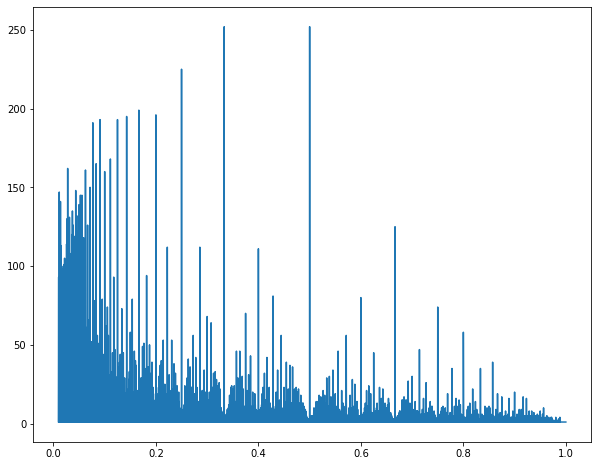

In [36]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,8)
plt.plot(time_df['time'], time_df['count'])
plt.show()

In [8]:
new_df = df[['user_id', 'product_id', 'time_spent']]
sparkdf=spark.createDataFrame(new_df)
sparkdf.show()

+---------+----------+------------------+
|  user_id|product_id|        time_spent|
+---------+----------+------------------+
|552255940|   5849378|0.0125619834710743|
|552255940|   5916414|0.0264462809917355|
|552255940|   5899247|0.1104132231404958|
|552255940|   5887734|0.0271074380165289|
|552255940|   5887734|0.0340495867768595|
|552255940|   5887256|0.0148760330578512|
|552255940|   5887254|0.0287603305785124|
|552255940|   5886557|0.0945454545454545|
|552255940|   5808510|0.0109090909090909|
|598956005|   5884230|0.0141651166118185|
|598956005|   5862943|0.0188868221490914|
|598956005|   5848907|0.0553727285734726|
|598956005|   5908741|0.0127342967520389|
|598956005|   5862936|0.0131635427099728|
|598956005|   5848410|0.0147374445557304|
|598956005|   5900667|0.0100157390184575|
|598956005|   5848905|0.0153097724996422|
|598956005|   5870838|0.0115896408642151|
|598956005|   5884362|0.0197453140649592|
|598956005|   5902893|0.0271855773358134|
+---------+----------+------------

In [38]:
sparkdf.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- product_id: long (nullable = true)
 |-- time_spent: double (nullable = true)



In [39]:
numerator = sparkdf.select("time_spent").count()

num_visitors = sparkdf.select("user_id").distinct().count()
num_pages = sparkdf.select("product_id").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_visitors * num_pages

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The time spent dataframe is ", "%.2f" % sparsity + "% empty.")

The time spent dataframe is  99.97% empty.


In [40]:
userId = sparkdf.groupBy("user_id").count().orderBy('count', ascending=False)
userId.show()

+---------+-----+
|  user_id|count|
+---------+-----+
|472338551|   79|
|567481084|   70|
|433876151|   60|
|408634781|   56|
|596179759|   56|
|578826194|   56|
|598828287|   54|
|596332446|   53|
|297321159|   53|
|556616475|   51|
|588910905|   49|
|552228404|   49|
|595577335|   47|
|596161554|   45|
|556692378|   45|
|594464428|   43|
|561678082|   42|
|587266779|   41|
|475253400|   40|
|553408825|   40|
+---------+-----+
only showing top 20 rows



In [41]:
productId = sparkdf.groupBy("product_id").count().orderBy('count', ascending=False)
productId.show()

+----------+-----+
|product_id|count|
+----------+-----+
|   5809910| 2571|
|   5809912| 1137|
|   5917178|  983|
|   5877454|  916|
|   5751383|  785|
|   5751422|  767|
|   5809911|  729|
|   5815662|  719|
|   5849033|  719|
|   5789668|  677|
|   5700037|  645|
|   5854897|  636|
|   5802432|  632|
|   5792800|  592|
|   5528035|  549|
|   5856186|  502|
|   5686925|  472|
|   5816170|  432|
|   5909810|  416|
|   5814046|  413|
+----------+-----+
only showing top 20 rows



In [42]:
training_df, validation_df = sparkdf.randomSplit([.95, .05])

In [43]:
training_df.show(), validation_df.show()

+--------+----------+------------------+
| user_id|product_id|        time_spent|
+--------+----------+------------------+
|25300038|   5673462|0.0117899249732047|
|25300038|   5799041|0.0203644158628081|
|25300038|   5799048|0.2181136120042872|
|25300038|   5799086|0.1918542336548767|
|25300038|   5806947|0.0337620578778135|
|25300038|   5810907|0.3756698821007502|
|25300038|   5900460|0.0632368703108253|
|25300038|   5910557|0.0498392282958199|
|25300038|   5915106|0.0257234726688102|
|31272873|   5773382|0.0151546180626663|
|31272873|   5912993|0.0495596969076387|
|35753172|   5528034|0.3696682464454976|
|35753172|   5635087|0.0268562401263823|
|35753172|   5635097|0.0616113744075829|
|35753172|   5645122|0.1200631911532385|
|35753172|   5687470|0.0505529225908372|
|35753172|   5687480|0.1469194312796208|
|35753172|   5687480|0.1721958925750395|
|35753172|   5857296|0.0363349131121642|
|46383252|   5528034|0.0284031866989954|
+--------+----------+------------------+
only showing top

(None, None)

In [44]:
import threading
# class model:
def model(iterations, regularization_parameter, rank):
    als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=rank, userCol="user_id", itemCol="product_id", ratingCol="time_spent")
    tempmodel = als.fit(training_df)
    predictions = tempmodel.transform(validation_df)
    new_predictions = predictions.filter(col('prediction') != np.nan)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="time_spent", predictionCol="prediction")
    rmse = evaluator.evaluate(new_predictions)
    l = [float(rmse), regularization_parameter, rank, tempmodel]
    queue.put(l)

In [45]:
global queue
from queue import Queue
queue = Queue()
threads = list()

In [46]:
best_regularization_parameter = 0
best_rank = 0
best_rmse = float('inf')
best_model = None
iterations = 10
ranks = [150]
regularization_parameters = [.01]
for rank in ranks:
    for regularization_parameter in regularization_parameters:
        t = threading.Thread(target=model, args=(iterations, regularization_parameter, rank))
        threads.append(t)
        t.start()
        
for thread in threads:
    thread.join()
    result = queue.get()
    print(result)
    if best_rmse > result[0]:
        best_regularization_parameter = result[1]
        best_rank = result[2]
        best_rmse = result[0]
        best_model = result[3]

[0.1994423946524291, 0.01, 150, ALSModel: uid=ALS_fc3963796f33, rank=150]


In [47]:
# Generate top 5 products recommendation for each Visitor
userRecommends = best_model.recommendForAllUsers(5).show(5, False)
# Genearte top 5 Visitors recommendations for each Product
bookrecommends = best_model.recommendForAllItems(5).show(5, False)

C:\Users\HP\Anaconda3\lib\site-packages\pyspark\sql\context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+---------+---------------------------------------------------------------------------------------------------------------------+
|user_id  |recommendations                                                                                                      |
+---------+---------------------------------------------------------------------------------------------------------------------+
|129675214|[{5834733, 0.31760907}, {5884070, 0.29854736}, {5911777, 0.23756997}, {5731393, 0.15841499}, {5788136, 0.15379849}]  |
|230350829|[{5809923, 0.29106852}, {5916716, 0.17229748}, {9169, 0.15024123}, {24336, 0.14903803}, {5885035, 0.13809793}]       |
|234024900|[{5862289, 0.21793914}, {5643947, 0.16696614}, {5622678, 0.16468944}, {5796874, 0.15611377}, {5911777, 0.1364448}]   |
|235005368|[{5823012, 0.06412994}, {5911777, 0.056241356}, {5803893, 0.05319129}, {5829504, 0.04932932}, {5842622, 0.049281098}]|
|236532316|[{5540779, 0.1887059}, {5819891, 0.17305185}, {5805913, 0.11497839}, {5881601, 

In [11]:
!pip install recommenders

  Using cached recommenders-1.1.0-py3-none-any.whl
  Using cached memory_profiler-0.60.0-py3-none-any.whl
  Using cached numba-0.55.1-cp37-cp37m-win_amd64.whl (2.4 MB)
  Using cached PyYAML-5.4.1-cp37-cp37m-win_amd64.whl (210 kB)
  Using cached cornac-1.14.2-cp37-cp37m-win_amd64.whl (2.4 MB)
  Using cached category_encoders-1.3.0-py2.py3-none-any.whl (61 kB)
  Using cached transformers-4.19.2-py3-none-any.whl (4.2 MB)
  Using cached Bottleneck-1.3.4-cp37-cp37m-win_amd64.whl (109 kB)
  Using cached pandera-0.9.0-py3-none-any.whl (197 kB)
  Using cached lightfm-1.16-cp37-cp37m-win_amd64.whl
  Using cached lightgbm-3.3.2-py3-none-win_amd64.whl (1.0 MB)
  Using cached scikit_surprise-1.1.1-cp37-cp37m-win_amd64.whl
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)
  Using cached statsmodels-0.13.2-cp37-cp37m-win_amd64.whl (9.0 MB)
  Using cached powerlaw-1.5-py3-none-any.whl (24 kB)
  Using cached llvmlite-0.38.1-cp37-cp37m-win_amd64.whl (23.2 MB)
  Using cached pyarrow-8.0.0-cp37-cp

In [2]:
# set the environment path to find Recommenders
import sys
import pyspark
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from recommenders.utils.timer import Timer
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRatingEvaluation, SparkRankingEvaluation
from recommenders.utils.spark_utils import start_or_get_spark

print("System version: {}".format(sys.version))
print("Spark version: {}".format(pyspark.__version__))

System version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Spark version: 3.2.1


In [6]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
DATA_SIZE = len(df)

In [7]:
# the following settings work well for debugging locally on VM - change when running on a cluster
# set up a giant single executor with many threads and specify memory cap
spark = start_or_get_spark("ALS PySpark", memory="16g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

In [9]:
train, test = spark_random_split(sparkdf, ratio=0.95, seed=123)
print ("N train", train.cache().count())
print ("N test", test.cache().count())

N train 277575
N test 14450


In [10]:
header = {
    "userCol": 'user_id',
    "itemCol": 'product_id',
    "ratingCol": 'time_spent',
}


als = ALS(
    rank=10,
    maxIter=15,
    implicitPrefs=False,
    regParam=0.05,
    coldStartStrategy='drop',
    nonnegative=False,
    seed=42,
    **header
)

In [11]:
with Timer() as train_time:
    model = als.fit(train)

print("Took {} seconds for training.".format(train_time.interval))

Took 34.16330260000001 seconds for training.


In [ ]:
with Timer() as test_time:

    # Get the cross join of all user-item pairs and score them.
    users = train.select('user_id').distinct()
    items = train.select('product_id').distinct()
    user_item = users.crossJoin(items)
    dfs_pred = model.transform(user_item)

    # Remove seen items.
    dfs_pred_exclude_train = dfs_pred.alias("pred").join(
        train.alias("train"),
        (dfs_pred['user_id'] == train['user_id']) & (dfs_pred['product_id'] == train['product_id']),
        how='outer'
    )

    top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train[f"train.{'time_spent'}"].isNull()) \
        .select('pred.' + 'user_id', 'pred.' + 'product_id', 'pred.' + "prediction")

    # In Spark, transformations are lazy evaluation
    # Use an action to force execute and measure the test time 
    top_all.cache().count()

print("Took {} seconds for prediction.".format(test_time.interval))

In [ ]:
top_all.show()

In [ ]:
rank_eval = SparkRankingEvaluation(test, top_all, k = TOP_K, col_user='user_id', col_item='product_id', 
                                    col_rating='time_spent', col_prediction="prediction", 
                                    relevancy_method="top_k")

In [ ]:
print("Model:\tALS",
      "Top K:\t%d" % rank_eval.k,
      "MAP:\t%f" % rank_eval.map_at_k(),
      "NDCG:\t%f" % rank_eval.ndcg_at_k(),
      "Precision@K:\t%f" % rank_eval.precision_at_k(),
      "Recall@K:\t%f" % rank_eval.recall_at_k(), sep='\n')

In [12]:
# Generate predicted ratings.
prediction = model.transform(test)
prediction.cache().show()

+---------+----------+------------------+------------+
|  user_id|product_id|        time_spent|  prediction|
+---------+----------+------------------+------------+
|595792732|     35361|0.0445402298850574| 0.022609295|
|480977653|   5563822|0.0423340961098398|0.0032775076|
|595719420|   5652853|               0.4|  0.14327641|
|512340178|   5670001|0.0740597130670802|  0.04282098|
|582815057|   5670001|0.4745762711864407| 0.039356485|
|423999738|   5684650|0.2065613608748481|  0.04075388|
|596327104|   5695639|0.2332155477031802|  0.04512497|
|562741584|   5742957|0.0580105783995905|  0.06245369|
|597693974|   5742957|0.5737051792828686| 0.037323937|
|581039687|   5742957|0.2401166558651976|0.0144706145|
|581966609|   5742957|0.0248921749845964| 0.017711308|
|566755291|   5742957|0.0394489668127739| 0.052787207|
|592847712|   5742957|0.0121712044300876|  0.74187315|
|471659006|   5742957|0.0108575790991602|  0.01513554|
|545807322|   5742957|0.0467836257309941|  0.01807849|
|574335090

In [14]:
rating_eval = SparkRatingEvaluation(test, prediction, col_user='user_id', col_item='product_id', 
                                    col_rating='time_spent', col_prediction="prediction")

print("Model:\tALS rating prediction",
      "RMSE:\t%f" % rating_eval.rmse(),
      "MAE:\t%f" % rating_eval.mae(),
      "Explained variance:\t%f" % rating_eval.exp_var(),
      "R squared:\t%f" % rating_eval.rsquared(), sep='\n')

Model:	ALS rating prediction
RMSE:	0.195045
MAE:	0.099959
Explained variance:	-0.117892
R squared:	-0.245035
